<a href="https://colab.research.google.com/github/Elisep03/Binary-Image-Classification/blob/main/Project_for_NSDCWinter2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2018 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Cat vs. Dog Image Classification: Building a Convnet from Scratch

We will build a classifier model from scratch that is able to distinguish dogs from cats. We will follow these steps:

1. Explore the example data
2. Build a small convnet from scratch to solve our classification problem
3. Evaluate training and validation accuracy

Let's go!

## Explore the Example Data

Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2024-03-04 05:32:54--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.207, 142.251.6.207, 172.217.214.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   135MB/s    in 0.5s    

2024-03-04 05:32:54 (135 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets (see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) for a refresher on training, validation, and test sets), which in turn each contain `cats` and `dogs` subdirectories. Let's define each of these directories:

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.658.jpg', 'cat.176.jpg', 'cat.749.jpg', 'cat.799.jpg', 'cat.354.jpg', 'cat.939.jpg', 'cat.2.jpg', 'cat.13.jpg', 'cat.247.jpg', 'cat.791.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see

*   List item
*   List item

a fresh batch each time:

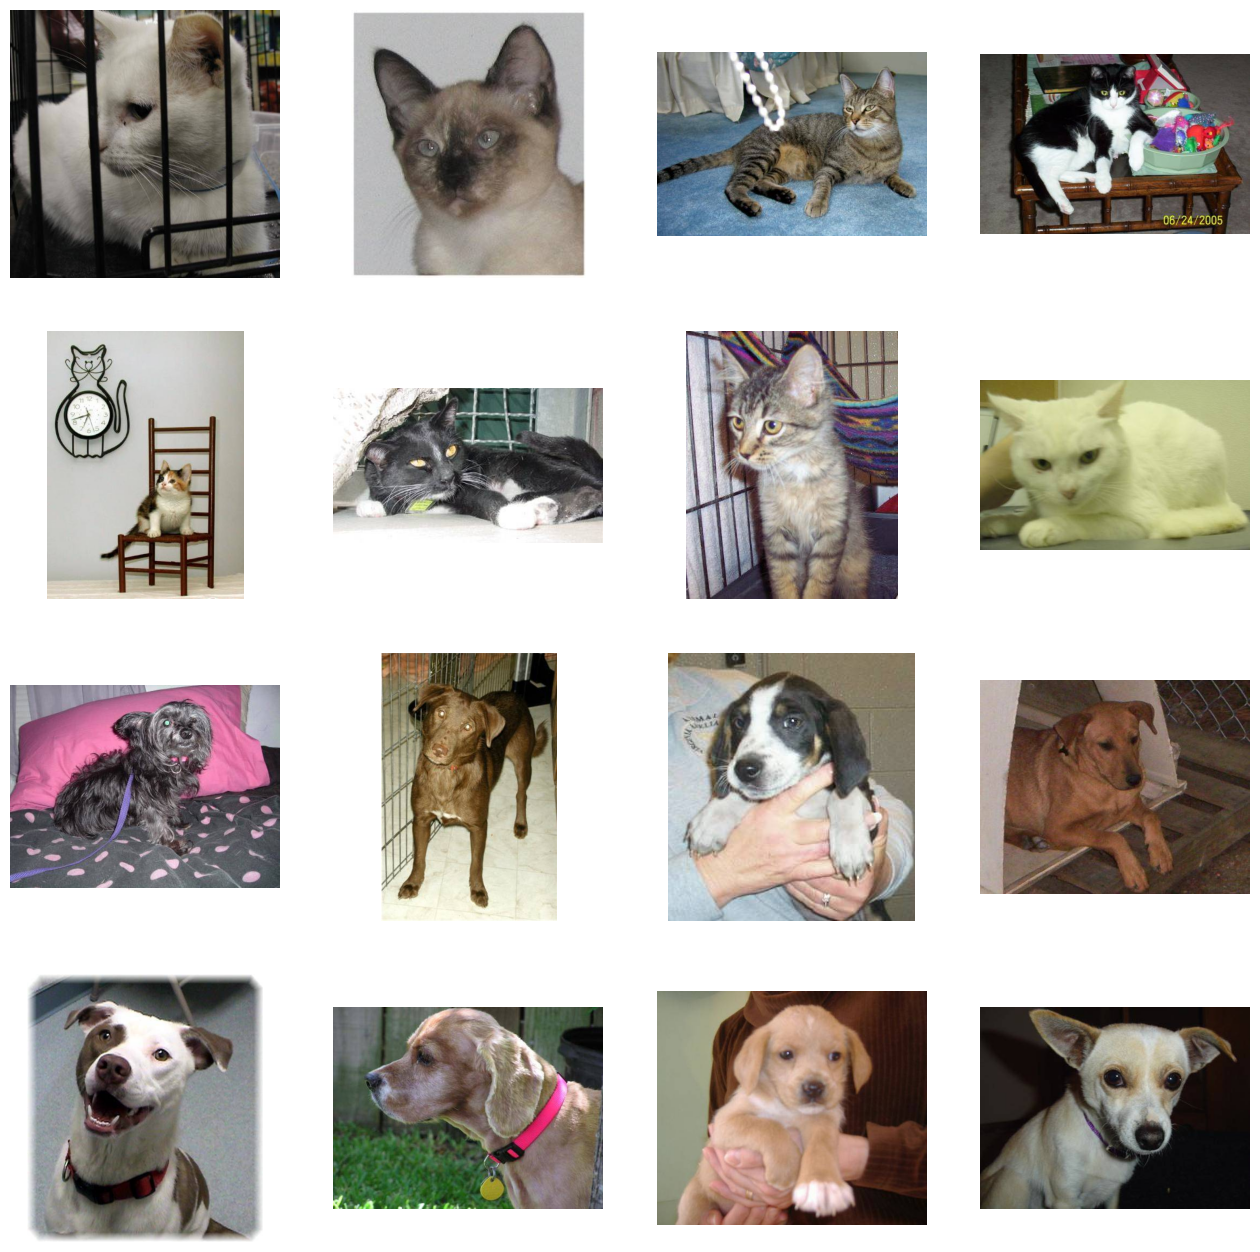

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building a Small Convnet from Scratch

The images that will go into our convnet are 150x150 color images.

**NOTE**: The first example CNN model, model_1, is a configuration that is widely used and known to work well for image classification. Namely, the configuration of stacking 3 {convolution + relu + maxpooling} modules, each convolutions having 3x3 windows, each maxpooling having 2x2 windows, having the number of convolution filters increase as we go to later layers. Also, since model_1 has relatively few training examples (1,000), using just three convolutional modules keeps the model small, which lowers the risk of overfitting.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

In [ ]:
# Our input feature is of dimension (150,150,3)

model_jordan = Sequential([
    layers.Conv2D(16, 3, activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_sam = Sequential([
    layers.Input(shape = (150, 150, 3)),
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', kernel_initializer = 'he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', kernel_initializer = 'glorot_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters = 128, kernel_size = (2,2), activation = 'relu', kernel_initializer = 'random_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(units = 64, activation = 'relu'),
    layers.Dense(units = 128, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
model_jackie = Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(40, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(80, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(150, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(700, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_evan = Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(20, 3, activation='relu', kernel_initializer = "lecun_uniform"),
    layers.MaxPooling2D(2),
    layers.Conv2D(60, 3, activation='relu', padding = "same", kernel_initializer = "lecun_uniform"),
    layers.MaxPooling2D(2),
    layers.Conv2D(100, 3, activation='relu', padding = "same"),
    layers.MaxPooling2D(2),
    layers.Dropout(0.3),
    layers.Conv2D(160, 3, activation='relu', padding = "same"),
    layers.MaxPooling2D(3),
    layers.Dropout(0.6),
    layers.Conv2D(200, 3, activation='relu', padding = "same"),
    layers.MaxPooling2D(3),
    layers.Flatten(),
    layers.Dense(616, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_max = Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(filters = 64, kernel_size = (2, 2), activation = 'relu', kernel_initializer = 'he_normal'),
    layers.MaxPooling2D(2),
    layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_normal'),
    layers.MaxPooling2D(2),
    layers.Conv2D(filters = 64, kernel_size = (4, 4), activation = 'relu', kernel_initializer = 'he_normal'),
    layers.AveragePooling2D(2),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_rosie = Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(16, 3, activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_saumya = Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(4, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(8, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_elise = Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(5, 9, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(30, 4, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(11, 2, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
 ])

We can summarize the model architecture:

In [ ]:
# sample model summary

model_sam.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_6 (Bat  (None, 148, 148, 32)      128       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_7 (Bat  (None, 72, 72, 64)      

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the feature map.

Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid. (For a refresher on loss metrics, see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

In [ ]:
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad, SGD, Adadelta, Nadam, Ftrl, Adamax

# besides the optimizers used below, here are the keyword arguments for other optimizers:
# optimizer = SGD(learning_rate=0.01, momentum=0.9)
# optimizer = Adadelta(learning_rate=1.0, rho=0.95)
# optimizer = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
# optimizer = FTRL(learning_rate=0.001, learning_rate_power=-0.5, initial_accumulator_value=0.1, l1_regularization_strength=0.0, l2_regularization_strength=0.0)
# optimizer = Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)

model_jordan.compile(Adadelta(learning_rate=1.0, rho=0.95),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_sam.compile(optimizer = Adam(learning_rate = 0.001),
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])

model_jackie.compile(loss='binary_crossentropy',
                     optimizer=RMSprop(learning_rate= 0.0001),
                     metrics = ['accuracy'])

model_evan.compile(loss = 'binary_crossentropy',
                   optimizer = RMSprop(learning_rate=0.0008),
                   metrics = ['accuracy'])

model_max.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.003),
              metrics=['acc'])

model_rosie.compile(loss='binary_crossentropy',
              optimizer=SGD(learning_rate=0.01),
              metrics=['acc'])

model_saumya.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

model_elise.compile(loss = 'binary_crossentropy',
                    optimizer = Adamax(learning_rate = 0.003,
                                       beta_1=0.9, beta_2=0.999),
                    metrics = ['acc'])

# model_1.compile(loss='binary_crossentropy',
#               optimizer=RMSprop(learning_rate=0.0001),
#               metrics=['acc'])

# model_2.compile(loss='binary_crossentropy',
#               optimizer=Adam(learning_rate=0.005),
#               metrics=['acc'])

# model_3.compile(loss='binary_crossentropy',
#               optimizer=Adagrad(learning_rate=0.001),
#               metrics=['acc'])

<details>
  <summary>something that may work well</summary>
  <p>
Here is a suggestion from the original author of this code: In this case, using the <a href="https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp" target="_blank">RMSprop optimization algorithm</a>
    is preferable to <a href="https://developers.google.com/machine-learning/glossary/#SGD" target="_blank">stochastic gradient descent (SGD)</a>,
    because RMSprop automates learning-rate tuning for us.
    Other optimizers, such as <a href="https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam" target="_blank">Adam</a> and
    <a href="https://developers.google.com/machine-learning/glossary/#AdaGrad" target="_blank">Adagrad</a>, also automatically adapt
    the learning rate during training and would work equally well here.
</p>
</details>

## Now for our ensemble model!

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Average

# Input layer for the ensemble model
input_layer = Input(shape=(150, 150, 3))
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU

# USe the previously defined models as the first step in our ensemble model
output_model_1 = model_jordan(input_layer)
output_model_2 = model_sam(input_layer)
output_model_3 = model_jackie(input_layer)
output_model_4 = model_evan(input_layer)
output_model_5 = model_max(input_layer)
output_model_6 = model_rosie(input_layer)
output_model_7 = model_saumya(input_layer)
output_model_8 = model_elise(input_layer)

# Average the outputs of the three models
average_output = Average()([output_model_1, output_model_2, output_model_3,
                            output_model_4, output_model_5, output_model_6,
                            output_model_7, output_model_8])

# Add additional layers to increase complexity
dense_layer1 = layers.Dense(256, activation='relu')(average_output)
dropout_layer1 = Dropout(0.5)(dense_layer1)
batchnorm_layer1 = BatchNormalization()(dropout_layer1)
dense_layer2 = layers.Dense(128, activation='relu')(batchnorm_layer1)
dropout_layer2 = Dropout(0.5)(dense_layer2)
batchnorm_layer2 = BatchNormalization()(dropout_layer2)
dense_layer3 = layers.Dense(64, activation='relu')(batchnorm_layer2)
dropout_layer3 = Dropout(0.5)(dense_layer3)
batchnorm_layer3 = BatchNormalization()(dropout_layer3)
dense_layer4 = layers.Dense(32, activation='relu')(batchnorm_layer3)
leaky_relu_layer = LeakyReLU()(dense_layer4)
ensemble_output = layers.Dense(1, activation='sigmoid')(leaky_relu_layer)

ensemble_model = Model(inputs=input_layer, outputs=ensemble_output)

# Display the ensemble model summary
ensemble_model.summary()

# Compile the ensemble model
ensemble_model.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(learning_rate=0.001),
                      metrics=['accuracy'])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 sequential_9 (Sequential)   (None, 1)                    1207457   ['input_17[0][0]']            
                                                                                                  
 sequential_10 (Sequential)  (None, 1)                    1009689   ['input_17[0][0]']            
                                                          7                                       
                                                                                                  
 sequential_11 (Sequential)  (None, 1)                    3048455   ['input_17[0][0]']      

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training
Let's train on all 2,000 images available, for 15 epochs, and validate on all 1,000 validation images. (This may take a few minutes to run.)

In [ ]:
# Model training

history_jordan = model_jordan.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1
)

Epoch 1/15
100/100 [==============================] - 7s 60ms/step - loss: 0.7039 - accuracy: 0.4995 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/15
100/100 [==============================] - 5s 51ms/step - loss: 0.6937 - accuracy: 0.5045 - val_loss: 0.6931 - val_accuracy: 0.4970
Epoch 3/15
100/100 [==============================] - 5s 51ms/step - loss: 0.6933 - accuracy: 0.5270 - val_loss: 0.6914 - val_accuracy: 0.5030
Epoch 4/15
100/100 [==============================] - 6s 60ms/step - loss: 0.6816 - accuracy: 0.5815 - val_loss: 0.6542 - val_accuracy: 0.5870
Epoch 5/15
100/100 [==============================] - 6s 59ms/step - loss: 0.6407 - accuracy: 0.6345 - val_loss: 0.6414 - val_accuracy: 0.6350
Epoch 6/15
100/100 [==============================] - 5s 52ms/step - loss: 0.5913 - accuracy: 0.6930 - val_loss: 0.5679 - val_accuracy: 0.7010
Epoch 7/15
100/100 [==============================] - 5s 51ms/step - loss: 0.5423 - accuracy: 0.7235 - val_loss: 0.5548 - val_accuracy: 0.7100

In [ ]:
history_sam = model_sam.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1
)

Epoch 1/15
100/100 [==============================] - 10s 70ms/step - loss: 1.7969 - accuracy: 0.5705 - val_loss: 0.8739 - val_accuracy: 0.4800
Epoch 2/15
100/100 [==============================] - 6s 60ms/step - loss: 1.0686 - accuracy: 0.6880 - val_loss: 1.5316 - val_accuracy: 0.5280
Epoch 3/15
100/100 [==============================] - 7s 68ms/step - loss: 0.5753 - accuracy: 0.8045 - val_loss: 2.5330 - val_accuracy: 0.5640
Epoch 4/15
100/100 [==============================] - 7s 68ms/step - loss: 0.3609 - accuracy: 0.8785 - val_loss: 2.1992 - val_accuracy: 0.6310
Epoch 5/15
100/100 [==============================] - 6s 57ms/step - loss: 0.1310 - accuracy: 0.9525 - val_loss: 2.2244 - val_accuracy: 0.6550
Epoch 6/15
100/100 [==============================] - 7s 66ms/step - loss: 0.0532 - accuracy: 0.9840 - val_loss: 2.1928 - val_accuracy: 0.6910
Epoch 7/15
100/100 [==============================] - 6s 58ms/step - loss: 0.0316 - accuracy: 0.9890 - val_loss: 1.9823 - val_accuracy: 0.703

In [ ]:
history_jackie = model_jackie.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1
)

Epoch 1/15
100/100 [==============================] - 7s 55ms/step - loss: 0.6889 - accuracy: 0.5340 - val_loss: 0.6618 - val_accuracy: 0.6260
Epoch 2/15
100/100 [==============================] - 6s 56ms/step - loss: 0.6531 - accuracy: 0.6095 - val_loss: 0.6159 - val_accuracy: 0.6650
Epoch 3/15
100/100 [==============================] - 6s 64ms/step - loss: 0.6043 - accuracy: 0.6615 - val_loss: 0.6147 - val_accuracy: 0.6470
Epoch 4/15
100/100 [==============================] - 5s 55ms/step - loss: 0.5571 - accuracy: 0.7050 - val_loss: 0.5744 - val_accuracy: 0.6990
Epoch 5/15
100/100 [==============================] - 6s 65ms/step - loss: 0.5269 - accuracy: 0.7480 - val_loss: 0.5476 - val_accuracy: 0.7070
Epoch 6/15
100/100 [==============================] - 5s 54ms/step - loss: 0.4992 - accuracy: 0.7620 - val_loss: 0.5431 - val_accuracy: 0.7140
Epoch 7/15
100/100 [==============================] - 5s 54ms/step - loss: 0.4683 - accuracy: 0.7790 - val_loss: 0.5491 - val_accuracy: 0.7240

In [ ]:
history_max = model_max.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1
)

Epoch 1/15
100/100 [==============================] - 6s 54ms/step - loss: 2.9076 - acc: 0.5045 - val_loss: 0.6923 - val_acc: 0.5070
Epoch 2/15
100/100 [==============================] - 6s 63ms/step - loss: 0.7315 - acc: 0.5550 - val_loss: 0.6970 - val_acc: 0.5220
Epoch 3/15
100/100 [==============================] - 5s 52ms/step - loss: 0.6666 - acc: 0.6325 - val_loss: 0.5870 - val_acc: 0.6840
Epoch 4/15
100/100 [==============================] - 6s 61ms/step - loss: 0.6008 - acc: 0.7010 - val_loss: 0.6140 - val_acc: 0.6720
Epoch 5/15
100/100 [==============================] - 6s 62ms/step - loss: 0.5665 - acc: 0.7195 - val_loss: 0.6515 - val_acc: 0.6880
Epoch 6/15
100/100 [==============================] - 5s 53ms/step - loss: 0.4808 - acc: 0.7715 - val_loss: 0.5382 - val_acc: 0.7290
Epoch 7/15
100/100 [==============================] - 5s 52ms/step - loss: 0.4021 - acc: 0.8180 - val_loss: 0.6257 - val_acc: 0.7350
Epoch 8/15
100/100 [==============================] - 6s 61ms/step - 

In [ ]:
history_rosie = model_rosie.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1
)

Epoch 1/15
100/100 [==============================] - 7s 60ms/step - loss: 0.6919 - acc: 0.5160 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 2/15
100/100 [==============================] - 5s 49ms/step - loss: 0.6877 - acc: 0.5325 - val_loss: 0.6823 - val_acc: 0.6030
Epoch 3/15
100/100 [==============================] - 5s 54ms/step - loss: 0.6802 - acc: 0.5705 - val_loss: 0.6725 - val_acc: 0.6160
Epoch 4/15
100/100 [==============================] - 5s 55ms/step - loss: 0.6738 - acc: 0.5755 - val_loss: 0.6624 - val_acc: 0.6180
Epoch 5/15
100/100 [==============================] - 5s 51ms/step - loss: 0.6693 - acc: 0.5845 - val_loss: 0.6532 - val_acc: 0.6320
Epoch 6/15
100/100 [==============================] - 5s 50ms/step - loss: 0.6611 - acc: 0.5960 - val_loss: 0.6551 - val_acc: 0.6110
Epoch 7/15
100/100 [==============================] - 6s 58ms/step - loss: 0.6542 - acc: 0.6135 - val_loss: 0.6399 - val_acc: 0.6390
Epoch 8/15
100/100 [==============================] - 5s 52ms/step - 

In [ ]:
history_evan = model_evan.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1
)

Epoch 1/15
100/100 [==============================] - 8s 63ms/step - loss: 0.7718 - accuracy: 0.5085 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/15
100/100 [==============================] - 5s 53ms/step - loss: 0.6966 - accuracy: 0.5250 - val_loss: 0.6881 - val_accuracy: 0.5210
Epoch 3/15
100/100 [==============================] - 6s 62ms/step - loss: 0.6829 - accuracy: 0.5805 - val_loss: 0.6520 - val_accuracy: 0.6120
Epoch 4/15
100/100 [==============================] - 5s 53ms/step - loss: 0.6623 - accuracy: 0.6165 - val_loss: 0.6385 - val_accuracy: 0.6220
Epoch 5/15
100/100 [==============================] - 6s 62ms/step - loss: 0.6335 - accuracy: 0.6650 - val_loss: 0.6293 - val_accuracy: 0.6620
Epoch 6/15
100/100 [==============================] - 5s 53ms/step - loss: 0.6015 - accuracy: 0.6950 - val_loss: 0.5806 - val_accuracy: 0.6930
Epoch 7/15
100/100 [==============================] - 6s 62ms/step - loss: 0.5829 - accuracy: 0.7015 - val_loss: 0.6008 - val_accuracy: 0.6840

In [ ]:
history_saumya = model_saumya.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1
)

Epoch 1/15
100/100 [==============================] - 6s 53ms/step - loss: 0.6943 - acc: 0.5580 - val_loss: 0.6671 - val_acc: 0.5820
Epoch 2/15
100/100 [==============================] - 6s 57ms/step - loss: 0.6338 - acc: 0.6535 - val_loss: 0.6490 - val_acc: 0.6210
Epoch 3/15
100/100 [==============================] - 5s 51ms/step - loss: 0.5672 - acc: 0.7150 - val_loss: 0.6157 - val_acc: 0.6740
Epoch 4/15
100/100 [==============================] - 5s 49ms/step - loss: 0.5143 - acc: 0.7495 - val_loss: 0.5948 - val_acc: 0.6930
Epoch 5/15
100/100 [==============================] - 6s 58ms/step - loss: 0.4519 - acc: 0.7930 - val_loss: 0.6065 - val_acc: 0.6930
Epoch 6/15
100/100 [==============================] - 6s 59ms/step - loss: 0.3892 - acc: 0.8255 - val_loss: 0.6351 - val_acc: 0.6830
Epoch 7/15
100/100 [==============================] - 5s 51ms/step - loss: 0.3312 - acc: 0.8545 - val_loss: 0.6668 - val_acc: 0.7060
Epoch 8/15
100/100 [==============================] - 7s 67ms/step - 

In [ ]:
history_elise = model_elise.fit(
    train_generator,
    steps_per_epoch = 95,
    epochs = 15,
    validation_data = validation_generator,
    validation_steps = 50,
    verbose = 1
)

Epoch 1/15
95/95 [==============================] - 7s 63ms/step - loss: 0.6973 - acc: 0.4989 - val_loss: 0.6929 - val_acc: 0.5000
Epoch 2/15
95/95 [==============================] - 5s 53ms/step - loss: 0.6929 - acc: 0.5168 - val_loss: 0.6914 - val_acc: 0.5480
Epoch 3/15
95/95 [==============================] - 6s 63ms/step - loss: 0.6855 - acc: 0.5521 - val_loss: 0.6805 - val_acc: 0.5130
Epoch 4/15
95/95 [==============================] - 5s 53ms/step - loss: 0.6582 - acc: 0.6116 - val_loss: 0.6509 - val_acc: 0.6230
Epoch 5/15
95/95 [==============================] - 6s 63ms/step - loss: 0.6300 - acc: 0.6674 - val_loss: 0.6196 - val_acc: 0.6510
Epoch 6/15
95/95 [==============================] - 6s 62ms/step - loss: 0.6009 - acc: 0.6832 - val_loss: 0.6463 - val_acc: 0.6090
Epoch 7/15
95/95 [==============================] - 5s 53ms/step - loss: 0.5577 - acc: 0.7200 - val_loss: 0.6114 - val_acc: 0.6530
Epoch 8/15
95/95 [==============================] - 6s 63ms/step - loss: 0.5302 - a

In [ ]:
# Training the ensemble model
history_ensemble = ensemble_model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)

Epoch 1/15
100/100 - 26s - loss: 0.2155 - accuracy: 0.9265 - val_loss: 0.6823 - val_accuracy: 0.5000 - 26s/epoch - 261ms/step
Epoch 2/15
100/100 - 15s - loss: 0.0660 - accuracy: 0.9825 - val_loss: 0.8215 - val_accuracy: 0.5000 - 15s/epoch - 155ms/step
Epoch 3/15
100/100 - 16s - loss: 0.0421 - accuracy: 0.9870 - val_loss: 0.9383 - val_accuracy: 0.6640 - 16s/epoch - 159ms/step
Epoch 4/15
100/100 - 15s - loss: 0.0443 - accuracy: 0.9860 - val_loss: 0.7436 - val_accuracy: 0.7450 - 15s/epoch - 153ms/step
Epoch 5/15
100/100 - 16s - loss: 0.0335 - accuracy: 0.9885 - val_loss: 1.0455 - val_accuracy: 0.7240 - 16s/epoch - 160ms/step
Epoch 6/15
100/100 - 15s - loss: 0.0393 - accuracy: 0.9885 - val_loss: 1.4359 - val_accuracy: 0.7450 - 15s/epoch - 153ms/step
Epoch 7/15
100/100 - 15s - loss: 0.0119 - accuracy: 0.9960 - val_loss: 2.2214 - val_accuracy: 0.7410 - 15s/epoch - 153ms/step
Epoch 8/15
100/100 - 15s - loss: 0.0323 - accuracy: 0.9915 - val_loss: 2.4047 - val_accuracy: 0.7400 - 15s/epoch - 153

### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random cat or dog image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

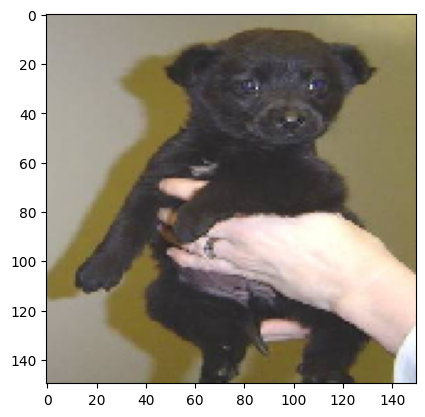

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

img_input = layers.Input(shape=(150, 150, 3))

# redefining a model using the Tensorflow Functional API
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_jordan_functional = Model(img_input, output_layer)

# Define a new model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after the first
successive_outputs = [layer.output for layer in model_jordan_functional.layers[1:]]
visualization_model = Model(inputs=img_input, outputs=successive_outputs)

# Prepare a random input image of a cat or dog from the training set
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
plt.imshow(img)
# display the chosen sample image
plt.show()

1/1 [==============================] - 0s 86ms/step


<ipython-input-69-e49b005643c0>:30: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
<ipython-input-69-e49b005643c0>:33: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


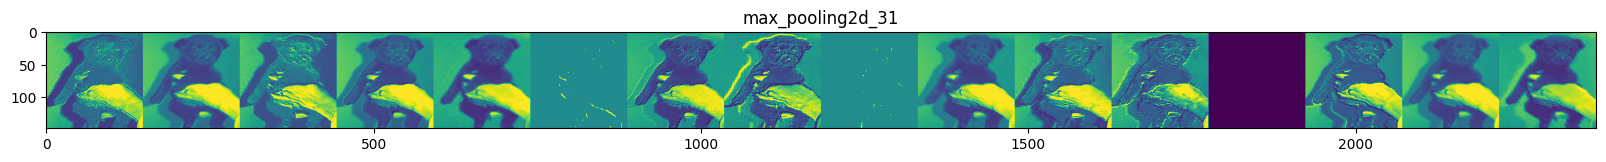

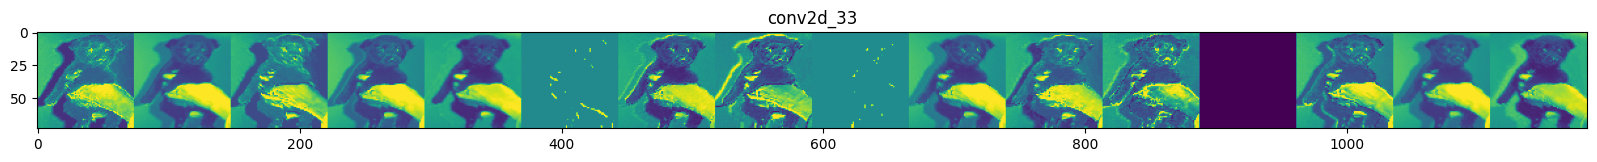

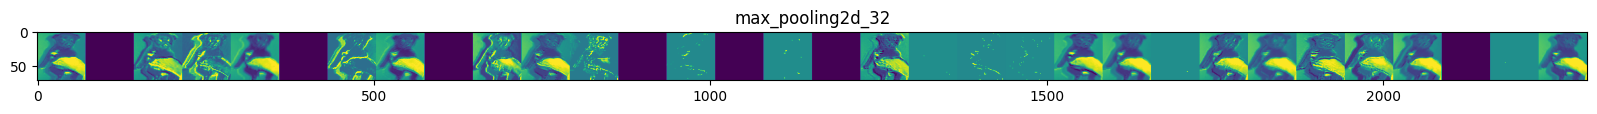

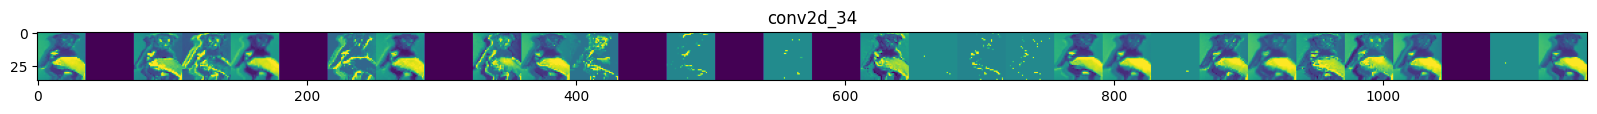

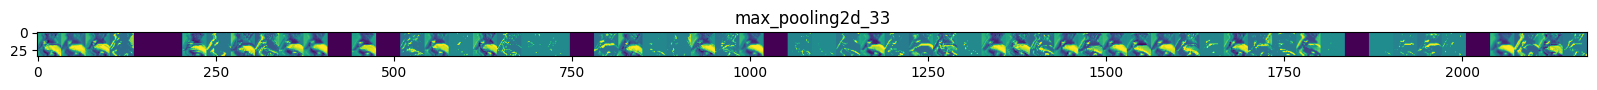

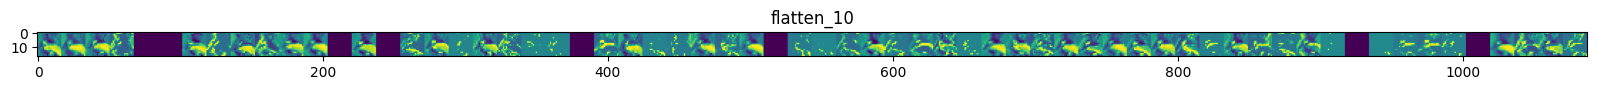

In [ ]:
# Visual representation of the convolutional layers
# we only visualize the conv layers and not the fully connected layers

x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Run our image through our network and thus obtain all
# intermediate representations for this image
successive_feature_maps = visualization_model.predict(x)

# Names of the layers, so that we can have them as part of our plot
layer_names = [layer.name for layer in model_jordan.layers[1:]]

# Display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # Tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

As you can see we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.


These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline.

### Evaluating Accuracy and Loss for the Model

Let's plot the training/validation accuracy and loss as collected during training:

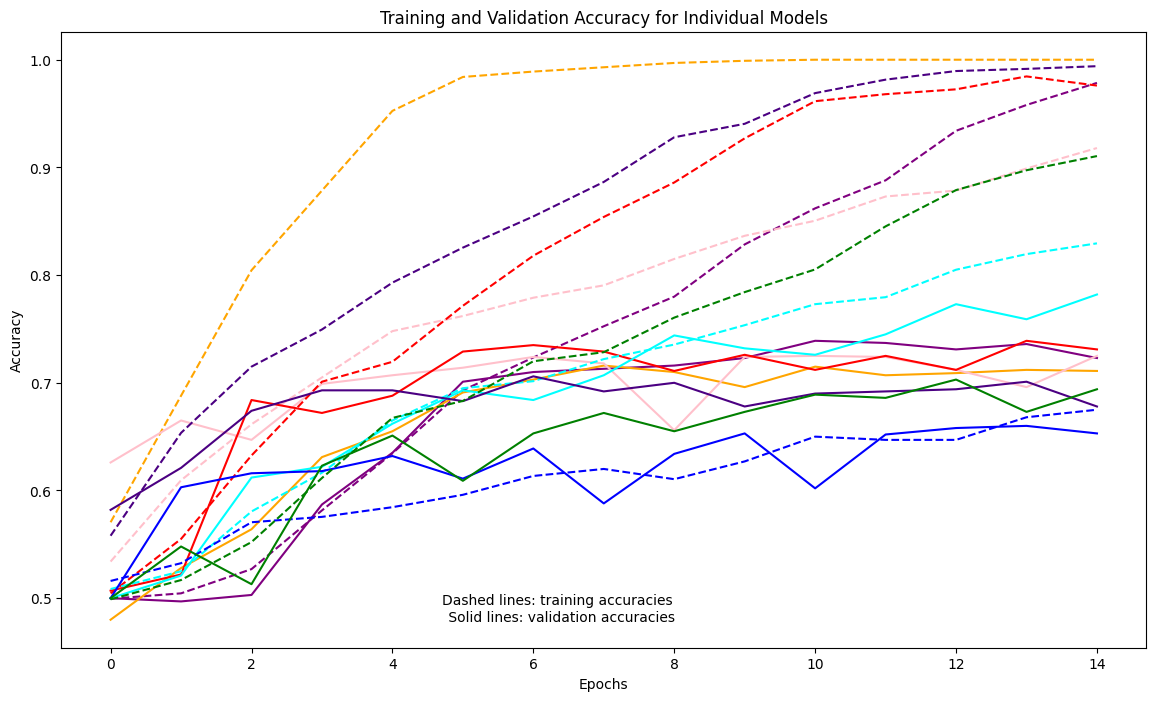

In [ ]:
# color for each model
color_model_jordan = 'purple'
color_model_sam = 'orange'
color_model_jackie = 'pink'
color_model_max = 'red'
color_model_evan = 'cyan'
color_model_rosie = 'blue'
color_model_saumya = 'indigo'
color_model_elise = 'green'

color_ensemble = 'black'

plt.figure(figsize=(14,8))

# Plotting training and validation accuracy for individual models
plt.plot(history_jordan.history['accuracy'], '--', label='Jordan\'s Training Acc', color=color_model_jordan)
plt.plot(history_jordan.history['val_accuracy'], label='Jordan\'s Validation Acc', color=color_model_jordan)

plt.plot(history_sam.history['accuracy'], '--', label='Sam\'s Training Acc', color=color_model_sam)
plt.plot(history_sam.history['val_accuracy'], label='Sam\'s Validation Acc', color=color_model_sam)

plt.plot(history_jackie.history['accuracy'], '--', label='Jackie\'s model Training Acc', color=color_model_jackie)
plt.plot(history_jackie.history['val_accuracy'], label='Jackie\'s model Validation Acc', color=color_model_jackie)

plt.plot(history_max.history['acc'], '--', label='Max\'s model Training Acc', color=color_model_max)
plt.plot(history_max.history['val_acc'], label='Max\'s model Validation Acc', color=color_model_max)

plt.plot(history_evan.history['accuracy'], '--', label='Evan\'s model Training Acc', color=color_model_evan)
plt.plot(history_evan.history['val_accuracy'], label='Evan\'s model Validation Acc', color=color_model_evan)

plt.plot(history_rosie.history['acc'], '--', label='Rosie\'s model Training Acc', color=color_model_rosie)
plt.plot(history_rosie.history['val_acc'], label='Rosie\'s model Validation Acc', color=color_model_rosie)

plt.plot(history_saumya.history['acc'], '--', label='Saumya\'s model Training Acc', color=color_model_saumya)
plt.plot(history_saumya.history['val_acc'], label='Saumya\'s model Validation Acc', color=color_model_saumya)

plt.plot(history_elise.history['acc'], '--', label='Elise\'s model Training Acc', color=color_model_elise)
plt.plot(history_elise.history['val_acc'], label='Elise\'s model Validation Acc', color=color_model_elise)


# Plotting training and validation accuracy for the ensemble model
# plt.plot(history_ensemble.history['accuracy'], '--', label='Ensemble Training Acc', color=color_ensemble)
# plt.plot(history_ensemble.history['val_accuracy'], label='Ensemble Validation Acc', color=color_ensemble)


# Display the plot
# plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy for Individual Models')
# Add text at the bottom of the plot
plt.annotate('Dashed lines: training accuracies \n Solid lines: validation accuracies', (0.4, 0.1), xycoords='figure fraction', ha='center')
plt.show()

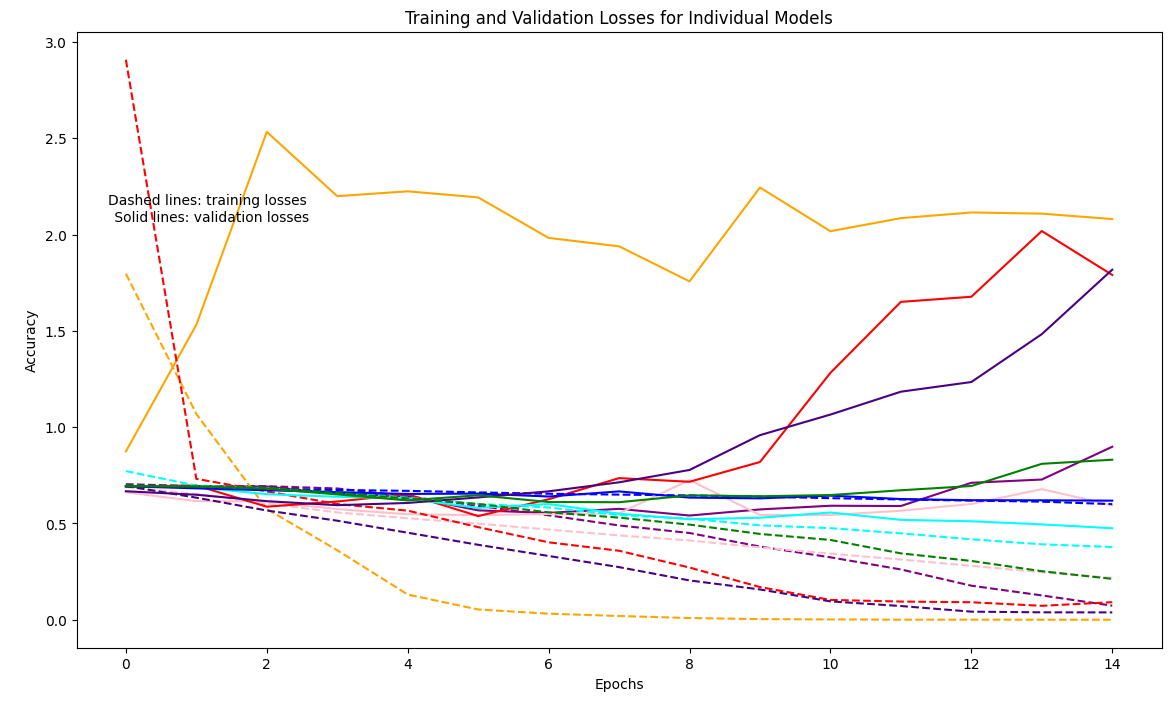

In [ ]:
#  Models' training and validation losses

plt.figure(figsize=(14,8))

plt.plot(history_jordan.history['loss'], '--', label='Jordan\'s Training Loss', color=color_model_jordan)
plt.plot(history_jordan.history['val_loss'], label='Jordan\'s Validation Loss', color=color_model_jordan)

plt.plot(history_sam.history['loss'], '--', label='Sam\'s model Training Loss', color=color_model_sam)
plt.plot(history_sam.history['val_loss'], label='Sam\'s model Validation Loss', color=color_model_sam)

plt.plot(history_jackie.history['loss'], '--', label='Jackie\'s model Training Loss', color=color_model_jackie)
plt.plot(history_jackie.history['val_loss'], label='Jackie\'s model Validation Loss', color=color_model_jackie)

plt.plot(history_max.history['loss'], '--', label='Max\'s model Training Loss', color=color_model_max)
plt.plot(history_max.history['val_loss'], label='Max\'s model Validation Loss', color=color_model_max)

plt.plot(history_evan.history['loss'], '--', label='Evan\'s model Training Loss', color=color_model_evan)
plt.plot(history_evan.history['val_loss'], label='Evan\'s model Validation Loss', color=color_model_evan)

plt.plot(history_rosie.history['loss'], '--', label='Rosie\'s model Training Loss', color=color_model_rosie)
plt.plot(history_rosie.history['val_loss'], label='Rosie\'s model Validation Loss', color=color_model_rosie)

plt.plot(history_saumya.history['loss'], '--', label='Saumya\'s Training Loss', color=color_model_saumya)
plt.plot(history_saumya.history['val_loss'], label='Saumya\'s Validation Loss', color=color_model_saumya)

plt.plot(history_elise.history['loss'], '--', label='Elise\'s model Training Loss', color=color_model_elise)
plt.plot(history_elise.history['val_loss'], label='Elise\'s model Validation Loss', color=color_model_elise)

# Plotting training and validation loss for the ensemble model
# plt.plot(history_ensemble.history['loss'], '--', label='Ensemble Training Loss', color=color_ensemble)
# plt.plot(history_ensemble.history['val_loss'], label='Ensemble Validation Loss', color=color_ensemble)

# Display the plot
# plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and Validation Losses for Individual Models')
# Add text at the bottom of the plot
plt.annotate('Dashed lines: training losses \n Solid lines: validation losses', (0.15, 0.6), xycoords='figure fraction', ha='center')
plt.show()

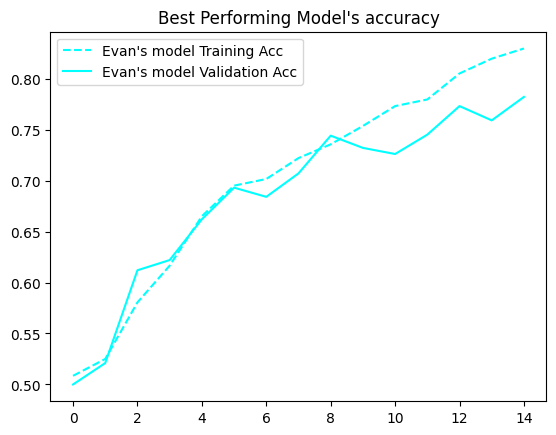

In [ ]:
# Best performing model


plt.plot(history_evan.history['accuracy'], '--', label='Evan\'s model Training Acc', color=color_model_evan)
plt.plot(history_evan.history['val_accuracy'], label='Evan\'s model Validation Acc', color=color_model_evan)

plt.title("Best Performing Model's accuracy")
plt.legend()
plt.show()


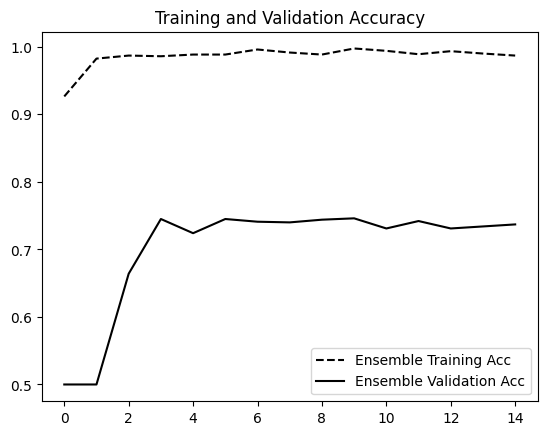

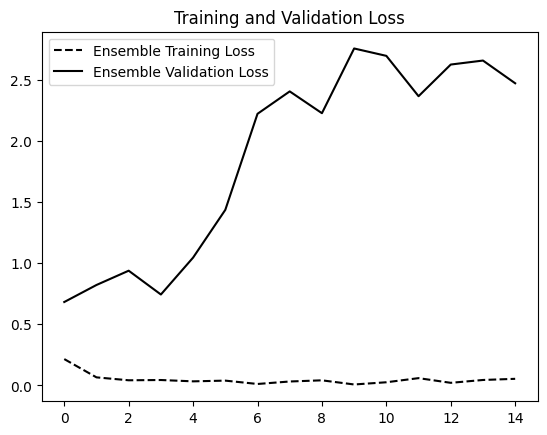

In [ ]:
# showing just the result of our ensemble model

# Plotting training and validation accuracy for the ensemble model
plt.plot(history_ensemble.history['accuracy'], '--', label='Ensemble Training Acc', color=color_ensemble)
plt.plot(history_ensemble.history['val_accuracy'], label='Ensemble Validation Acc', color=color_ensemble)

plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plotting training and validation loss for the ensemble model
plt.plot(history_ensemble.history['loss'], '--', label='Ensemble Training Loss', color=color_ensemble)
plt.plot(history_ensemble.history['val_loss'], label='Ensemble Validation Loss', color=color_ensemble)

plt.legend()
plt.title('Training and Validation Loss')
plt.show()

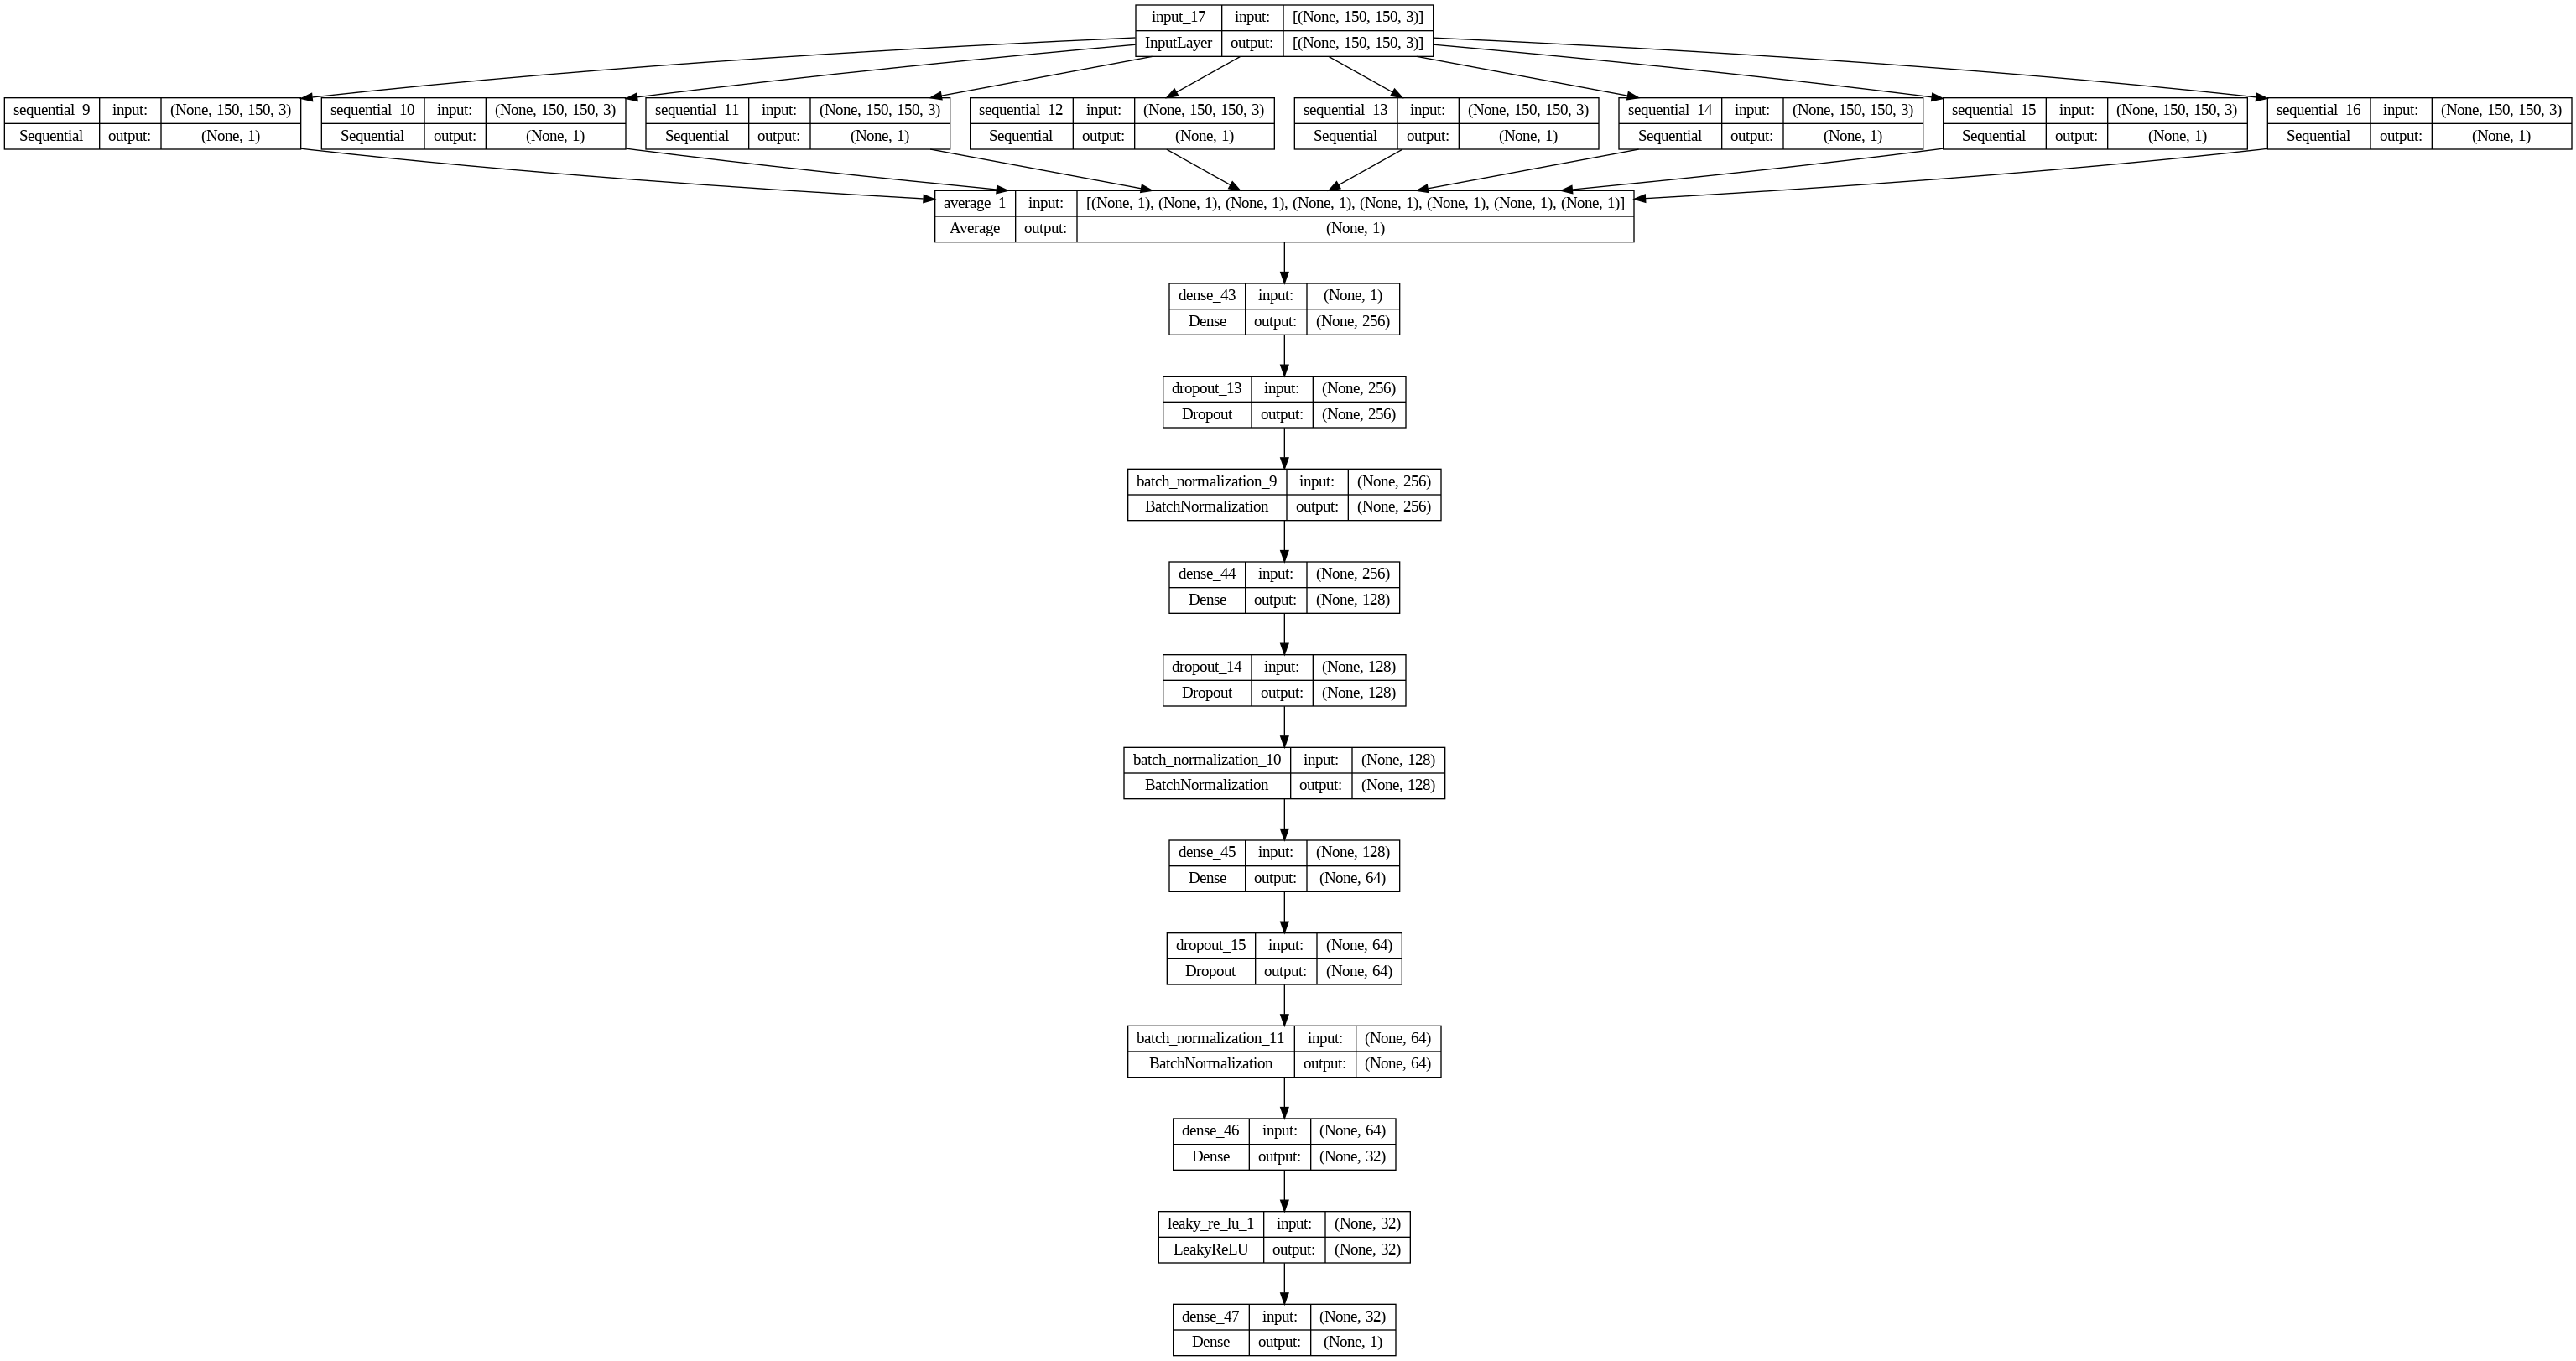

In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming your model is named 'model_evan'
plot_model(ensemble_model, to_file='model.png', show_shapes=True, show_layer_names=True)

#pip install pydot graphviz

from IPython.display import Image
Image(retina=True, filename='model.png')

# NOTES
#"None" means any batch sizes (the number of data pts in subsets of the data) can be used

In [ ]:
# Create a model that includes the layers up to the 5th layer of the original model
model_partial = Model(inputs=ensemble_model.inputs, outputs=ensemble_model.layers[9].output)

# Now you can visualize this partial model
plot_model(model_partial, to_file='model_partial.png', show_shapes=True, show_layer_names=True)

from PIL import Image, ImageDraw, ImageFont

# Open the image file
img = Image.open('model.png')

# Create ImageDraw object
draw = ImageDraw.Draw(img)

# Specify font size
font = ImageFont.load_default()
#font = ImageFont.truetype('/path/to/arial.ttf', 15)

# Add text
draw.text((0, 0), "Model Visualization", (0,0,0), font=font)

# Save the image
img.save('model_with_title.png')

ensemble_model.save('ensemble_model.h5')
#pip install netron
import subprocess

# Install netron using pip
subprocess.run(["pip", "install", "netron"])
import netron
netron.start('ensemble_model.h5')


Serving 'ensemble_model.h5' at http://localhost:8081


('localhost', 8081)